In [147]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [148]:

thickness_lst = []
wtw_thickness = []
refractive_lst = []
wtw_refractive = []
f = pd.ExcelFile('Data/O3 development.xlsx')

for name in f.sheet_names:
    if name == 'DOE':
        doe = pd.read_excel('Data/O3 development.xlsx', engine='openpyxl',sheet_name = 'DOE')
        doe = doe[doe.columns[-6::]]
        doe.columns = [['Ar (sccm)', 'O3 (sccm)', 'Turn on (s) TMA', 'Turn off (s) TMA','Turn off (s) Ozone','Turn off (s) Ozone']]
        doe = doe[1:]
        doe.index = ['Run{}'.format(x) for x in range(15,23)]
    else:
        cur_sheet = pd.read_excel('Data/O3 development.xlsx', engine='openpyxl',sheet_name = name)
        needed_cols = ['Unnamed: {}'.format(x) for x in range(2,13)]
        thickness = cur_sheet[needed_cols][2:26].reset_index(drop = True)
        thickness.columns = ['SE testing point:{}'.format(x) for x in range(1, 10)]+['Avg', 'WIW']
        thickness_lst.append(thickness)
        
        refractive = cur_sheet[needed_cols][30::].reset_index(drop = True)
        refractive.columns = ['SE testing point:{}'.format(x) for x in range(1, 10)] + ['Avg','WIW']
        refractive_lst.append(refractive)
        
        wtw_thickness.append(cur_sheet['Unnamed: 13'].iloc[2])
        wtw_refractive.append(cur_sheet['Unnamed: 13'].iloc[30])

In [149]:
para = doe.to_numpy()
# rf = np.array(refractive_lst)
rf_wtw = np.array(wtw_refractive)
# tk = np.array(thickness_lst)
tk_wtw = np.array(wtw_thickness)

In [143]:
# choices of length scale upperbound and kernels as a list
length_scale_choices = [1000,100,10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
length_scale_choices.reverse()
res = []
def produce_kernels_scale(upperbounds,res):
    # upperbounds: a list of float denoting the upperbounds for length scale parameter of kernels
    # res: a list of kernel outputs
    for i in upperbounds:
        
        kernel_choices = [1.0 * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 1.0 * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL)+C(),
                 1.0 * Matern(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 1.0 * RationalQuadratic(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 C() * RBF(length_scale_bounds=(0,i)) + WhiteKernel(noise_level=NOISE_LEVEL),
                 DotProduct()+WhiteKernel(noise_level=NOISE_LEVEL)]

        res.extend(kernel_choices)
    return res

kernel_choices = produce_kernels_scale(length_scale_choices,res)
kernel_choices

[1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 DotProduct(sigma_0=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
 1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
 DotProduct(sigma_0=1) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05) + 1**2,
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(

In [144]:
### Data setup 
NUM_OF_DATA_POINTS = 20
NUM_OF_PLOT_POINTS = 100
# gp settings 
NOISE_LEVEL = 1e-5

kernel = 1.0 * RBF(length_scale=5) + WhiteKernel(noise_level=NOISE_LEVEL)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

In [145]:
X = para 
Y = np.array([tk_wtw,rf_wtw]).reshape(8,2)

In [146]:
#### Kernel setting and prediction
#### Taking out one data point and training on the rest, generating len(Y) different models
def model_performance(gp,kernel,X,Y):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)
    models = cross_validate(gp, X, Y, return_estimator = True,cv=len(Y),scoring="neg_mean_squared_error",return_train_score = True)
    for i in models["estimator"]:
        print("Learned kernel", str(i.kernel_))
    print("\n")
    print("test scores for each model",models['test_score'],"\n")
    print("negative mean squared error",models["train_score"],"\n")
    print("log marginal likelihood", [i.log_marginal_likelihood() for i in models["estimator"]],"\n")

for i in kernel_choices:
    model_performance(gp,i,X,Y)

Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)
Learned kernel 1**2 * RBF(length_scale=0) + WhiteKernel(noise_level=1e-05)


test scores for each model [nan nan nan nan nan nan nan nan] 

negative mean squared error [nan nan nan nan nan nan nan nan] 



AttributeError: 'GaussianProcessRegressor' object has no attribute 'log_marginal_likelihood_value_'

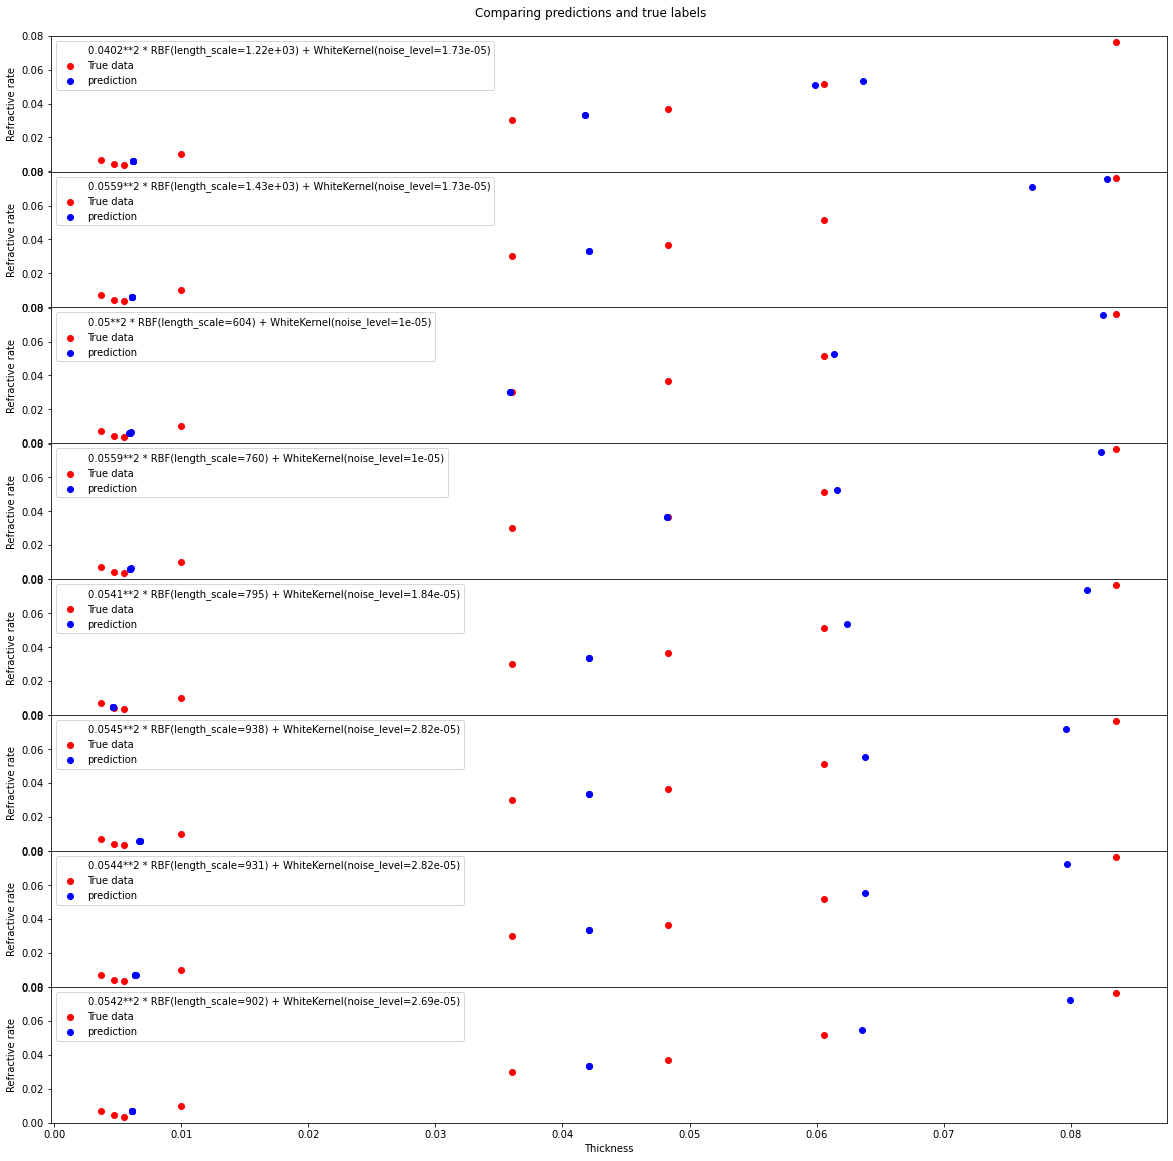

In [119]:
show_plot = True
num_models = len(models["estimator"])
if show_plot:
    fig = plt.figure(figsize=(20,20))
    gs = fig.add_gridspec(len(Y), hspace=0)
    axs = gs.subplots(sharex=True)
    fig.suptitle('Comparing predictions and true labels',y=0.9)
    for estimator, i in zip(models["estimator"],range(num_models)):
        axs[i].scatter(Y[:,0], Y[:,1],label="True data",color="r")
        prediction = estimator.predict(X)
        w = prediction[:,0]
        n = prediction[:,1]
        axs[i].scatter(w,n,label="prediction",color="b")
        axs[i].plot([], [], ' ', label=estimator.kernel_)
        axs[i].legend(loc="upper left")
        axs[i].set_ylabel("Refractive rate")
        
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    plt.xlabel("Thickness")